In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler 

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
# 设置随机种子以便结果可复现
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 1. 加载数据并初步处理
df = pd.read_csv("Potato-Prolific-Dataset-main/dataset/offensiveness/raw_data.csv")

print("原始数据集大小:", df.shape)
print("原始数据列名:", df.columns)

# 选择需要的列
df_selected = df[['text', 'offensiveness', 'race']].copy()

# 清理缺失值
df_selected.dropna(subset=['text', 'offensiveness', 'race'], inplace=True)
print("清理缺失值后数据集大小:", df_selected.shape)

# 将 offensiveness 转换为整数 (如果需要)
df_selected['offensiveness'] = df_selected['offensiveness'].astype(int)

原始数据集大小: (13035, 9)
原始数据列名: Index(['instance_id', 'user_id', 'text', 'offensiveness', 'gender', 'race',
       'age', 'occupation', 'education'],
      dtype='object')
清理缺失值后数据集大小: (13035, 3)


白人数据集大小: (9803, 3)

白人数据中 offensiveness 分布:
offensiveness
1    5671
2    1714
3    1170
4     756
5     492
Name: count, dtype: int64


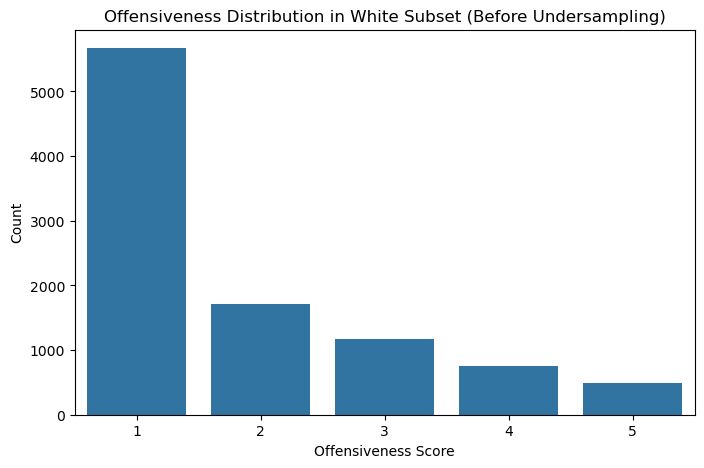

In [4]:
# 2. 筛选白人数据
df_white = df_selected[df_selected['race'] == 'White'].copy()
print(f"白人数据集大小: {df_white.shape}")

if df_white.empty:
    print("错误：筛选后没有白人数据。请检查数据集中的 'race' 字段和 'White' 值。")
    exit()

# 查看白人数据中 offensiveness 的分布
print("\n白人数据中 offensiveness 分布:")
print(df_white['offensiveness'].value_counts().sort_index())

# 绘制分布图
plt.figure(figsize=(8, 5))
sns.countplot(x='offensiveness', data=df_white, order=sorted(df_white['offensiveness'].unique()))
plt.title('Offensiveness Distribution in White Subset (Before Undersampling)')
plt.xlabel('Offensiveness Score')
plt.ylabel('Count')
plt.show()

In [5]:
# 3. 准备标签
# BERT的 CrossEntropyLoss 通常期望标签从0开始，所以我们将1-5的评分调整为0-4
df_white['labels'] = df_white['offensiveness'] - 1
num_classes = df_white['labels'].nunique()
print(f"\n类别数量: {num_classes}")
print("调整后的标签分布 (0-4):")
print(df_white['labels'].value_counts().sort_index())


类别数量: 5
调整后的标签分布 (0-4):
labels
0    5671
1    1714
2    1170
3     756
4     492
Name: count, dtype: int64


In [6]:
# 4. 划分数据集 (训练集、验证集、测试集)
# 首先，从白人数据中分出测试集 (例如20%)，确保分层
train_val_df, test_df = train_test_split(
    df_white,
    test_size=0.2,
    stratify=df_white['labels'], # 按照调整后的标签分层
    random_state=SEED
)

# 然后，从剩余数据中分出训练集和验证集 (例如，训练集占剩余的80%，验证集占剩余的20%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2, # 相当于总数据的 0.8 * 0.2 = 0.16
    stratify=train_val_df['labels'], # 按照调整后的标签分层
    random_state=SEED
)

print(f"训练集大小: {train_df.shape}")
print(f"验证集大小: {val_df.shape}")
print(f"测试集大小: {test_df.shape}")

print("\n训练集标签分布:")
print(train_df['labels'].value_counts().sort_index())
print("\n验证集标签分布:")
print(val_df['labels'].value_counts().sort_index())
print("\n测试集标签分布:")
print(test_df['labels'].value_counts().sort_index())

训练集大小: (6273, 4)
验证集大小: (1569, 4)
测试集大小: (1961, 4)

训练集标签分布:
labels
0    3628
1    1097
2     749
3     484
4     315
Name: count, dtype: int64

验证集标签分布:
labels
0    908
1    274
2    187
3    121
4     79
Name: count, dtype: int64

测试集标签分布:
labels
0    1135
1     343
2     234
3     151
4      98
Name: count, dtype: int64



训练集大小: (6273, 4)
训练集标签分布:
labels
0    3628
1    1097
2     749
3     484
4     315
Name: count, dtype: int64


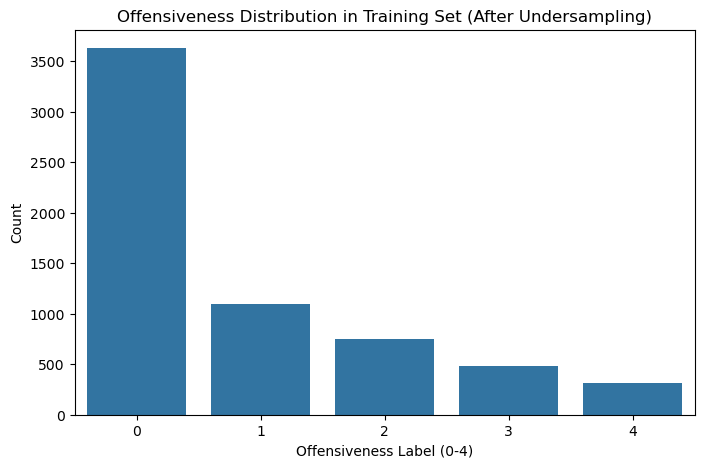

In [7]:
print(f"\n训练集大小: {train_df.shape}")
print("训练集标签分布:")
print(train_df['labels'].value_counts().sort_index())

# 绘制欠采样后训练集分布图
plt.figure(figsize=(8, 5))
sns.countplot(x='labels', data=train_df, order=sorted(train_df['labels'].unique()))
plt.title('Offensiveness Distribution in Training Set (After Undersampling)')
plt.xlabel('Offensiveness Label (0-4)')
plt.ylabel('Count')
plt.show()

In [8]:
# 6. 计算类别权重 (Class Weights)
# 基于欠采样后的训练集计算权重
class_labels = np.unique(train_df['labels'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['labels'].values
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"\n类别标签: {class_labels}")
print(f"类别权重: {class_weights}")
print(f"类别权重张量 (on {device}): {class_weights_tensor}")



类别标签: [0 1 2 3 4]
类别权重: [0.34581036 1.14366454 1.67503338 2.59214876 3.98285714]
类别权重张量 (on cuda): tensor([0.3458, 1.1437, 1.6750, 2.5921, 3.9829], device='cuda:0')


In [10]:
# 7. BERT Tokenizer 和 PyTorch Dataset
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

MAX_LENGTH = 128 # 根据你的文本长度分布调整

class OffensivenessDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 创建 Dataset 实例
train_dataset = OffensivenessDataset(
    texts=train_df['text'].values,
    labels=train_df['labels'].values,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

val_dataset = OffensivenessDataset(
    texts=val_df['text'].values,
    labels=val_df['labels'].values,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

test_dataset = OffensivenessDataset(
    texts=test_df['text'].values,
    labels=test_df['labels'].values,
    tokenizer=tokenizer,
    max_len=MAX_LENGTH
)

In [11]:
# 8. PyTorch DataLoaders
BATCH_SIZE = 8 # 根据GPU显存调整

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 检查一个批次的数据
sample_batch = next(iter(train_loader))
print("\nSample batch keys:", sample_batch.keys())
print("Sample batch input_ids shape:", sample_batch['input_ids'].shape)
print("Sample batch labels shape:", sample_batch['labels'].shape)


Sample batch keys: dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])
Sample batch input_ids shape: torch.Size([8, 128])
Sample batch labels shape: torch.Size([8])


In [12]:
# 9. 定义 BERT 模型
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes, # 我们的类别数是5 (0-4)
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)
print(f"\n模型已加载到 {device}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



模型已加载到 cuda


In [13]:
# 10. 训练设置
EPOCHS = 3 # 可以根据验证集表现调整
LEARNING_RATE = 2e-5 # BERT 常用学习率

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # 可以设置一个小的warmup
    num_training_steps=total_steps
)

# 损失函数，使用我们计算的类别权重
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)


d:\anaconda3\envs\py38\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# 11. 训练和验证函数
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for batch_idx, d in enumerate(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # outputs.logits 是模型的原始输出，形状为 (batch_size, num_classes)
        
        loss = loss_fn(outputs.logits, labels)

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 梯度裁剪
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        if (batch_idx + 1) % 50 == 0: # 每50个batch打印一次进度
             print(f'  Batch {batch_idx + 1}/{len(data_loader)}, Loss: {loss.item():.4f}')


    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss = loss_fn(outputs.logits, labels)

            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return correct_predictions.double() / n_examples, np.mean(losses), all_preds, all_labels

In [ ]:
# 12. 开始训练
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
best_val_accuracy = 0
patience_counter = 0
PATIENCE_LIMIT = 2
# best_model_state = None # No longer just model state, we save a full checkpoint

CHECKPOINT_PATH = "best_model_checkpoint.pth" # Define a path for the checkpoint

print("\Start training...")
for epoch in range(EPOCHS): # EPOCHS is the total number of epochs for this run
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_df)
    )
    print(f'Training set loss: {train_loss:.4f} | Training set accuracy: {train_acc:.4f}')

    val_acc, val_loss, _, _ = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_df)
    )
    print(f'Validation set loss: {val_loss:.4f} | Validation set accuracy: {val_acc:.4f}')

    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        print(f"New best validation set accuracy: {best_val_accuracy:.4f}. Save checkpoint to {CHECKPOINT_PATH}")
        torch.save({
            'epoch': epoch, # Save the epoch number (0-indexed)
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_accuracy': best_val_accuracy,
            'history': history,
            'class_weights_tensor': class_weights_tensor, # Save class weights if needed later
            'num_classes': num_classes, # Save num_classes
            'max_length': MAX_LENGTH # Save MAX_LENGTH
        }, CHECKPOINT_PATH)
    else:
        patience_counter += 1
        print(f"The validation set accuracy did not improve. Patience: {patience_counter}/{PATIENCE_LIMIT}")

    if patience_counter >= PATIENCE_LIMIT:
        print("When the early stopping condition is reached, the training stops.")
        break
    print()

# After the loop, load the best checkpoint to ensure the model object has the best weights
if os.path.exists(CHECKPOINT_PATH):
    print(f"Training ends or stops early. Load the best checkpoint {CHECKPOINT_PATH} into the model.")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device) # map_location is important if loading on different device
    model.load_state_dict(checkpoint['model_state_dict'])
    # Optimizer and scheduler states are not strictly needed here if we are just evaluating next,
    # but good to have them in the checkpoint for *continuing* training.
    print("The best model weights are loaded.")
else:
    print("Warning: No checkpoints were saved during training (it is possible that validation set accuracy never improved). The model from the last epoch will be used.")

# The rest of In[15], In[16], In[17] would follow, using the 'model' object
# which now (ideally) contains the weights from the best checkpoint.


\Start training...
Epoch 1/3
----------


d:\anaconda3\envs\py38\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  Batch 50/785, Loss: 1.5219
  Batch 100/785, Loss: 1.4618
  Batch 150/785, Loss: 1.5874
  Batch 200/785, Loss: 1.6101
  Batch 250/785, Loss: 1.5713
  Batch 300/785, Loss: 1.6047
  Batch 350/785, Loss: 1.6413
  Batch 400/785, Loss: 1.5493
  Batch 450/785, Loss: 1.3131
  Batch 500/785, Loss: 1.6396
  Batch 550/785, Loss: 1.5883
  Batch 600/785, Loss: 1.4864
  Batch 650/785, Loss: 1.3252
  Batch 700/785, Loss: 1.2880
  Batch 750/785, Loss: 1.8172
Training set loss: 1.5409 | Training set accuracy: 0.4288
Validation set loss: 1.5749 | Validation set accuracy: 0.5386
New best validation set accuracy: 0.5386. Save checkpoint to best_model_checkpoint.pth

Epoch 2/3
----------
  Batch 50/785, Loss: 1.6585
  Batch 100/785, Loss: 1.4740
  Batch 150/785, Loss: 1.6543
  Batch 200/785, Loss: 1.1117
  Batch 250/785, Loss: 1.0951
  Batch 300/785, Loss: 1.2884
  Batch 350/785, Loss: 1.4934
  Batch 400/785, Loss: 1.3025
  Batch 450/785, Loss: 2.0696
  Batch 500/785, Loss: 1.1695
  Batch 550/785, Loss: 

C:\Users\34800\AppData\Local\Temp\ipykernel_6344\3026271796.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=device

The best model weights are loaded.


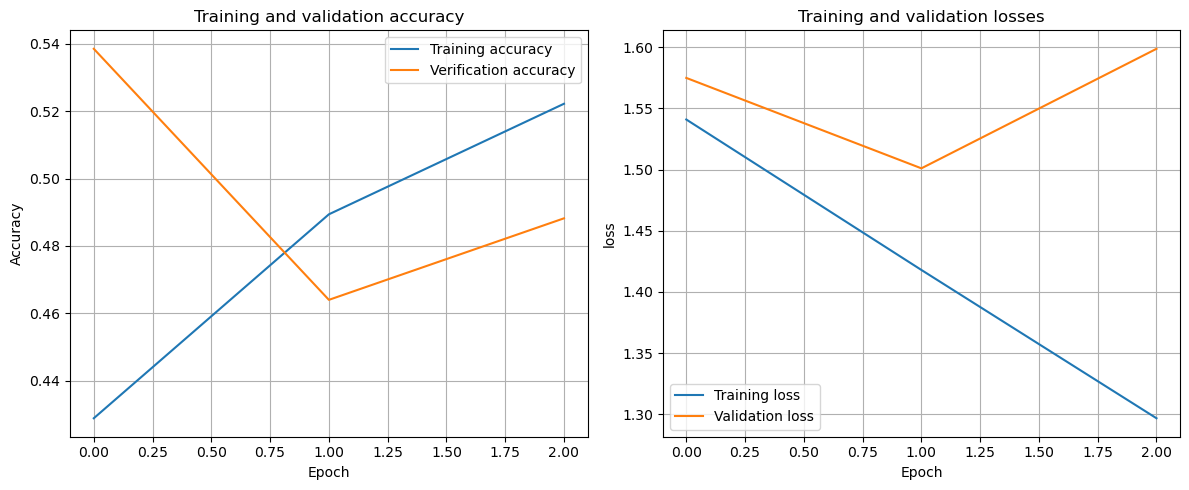

In [17]:
# 13. 绘制训练历史
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Verification accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
# 14. 在测试集上评估模型
print("\nEvaluate the model on the test set...")
test_acc, test_loss, test_preds, test_labels_true = eval_model(
    model,
    test_loader,
    loss_fn, # 这里的loss_fn也应该使用class_weights_tensor，尽管评估时主要看acc
    device,
    len(test_df)
)

print(f'Test set loss: {test_loss:.4f}')
print(f'Test set accuracy: {test_acc:.4f}')

# 详细的分类报告
# 将标签从 0-4 转换回 1-5，如果需要的话
# test_preds_original_scale = [p + 1 for p in test_preds]
# test_labels_true_original_scale = [l + 1 for l in test_labels_true]
# target_names_original_scale = [str(i) for i in range(1, num_classes + 1)]

# 使用 0-4 范围的标签
target_names = [str(i) for i in range(num_classes)] # '0', '1', '2', '3', '4'

print("\nTest set classification report (labels 0-4):")
try:
    report = classification_report(test_labels_true, test_preds, target_names=target_names, zero_division=0)
    print(report)
except ValueError as e:
    print(f"Error while generating classification report: {e}")
    print("This may be because some categories in the test set were not predicted or some categories are missing in the true labels.")
    print("True label distribution:", pd.Series(test_labels_true).value_counts().sort_index())
    print("Predicted label distribution:", pd.Series(test_preds).value_counts().sort_index())


Evaluate the model on the test set...
Test set loss: 1.5779
Test set accuracy: 0.5171

Test set classification report (labels 0-4):
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      1135
           1       0.21      0.35      0.26       343
           2       0.22      0.03      0.06       234
           3       0.15      0.10      0.12       151
           4       0.17      0.02      0.04        98

    accuracy                           0.52      1961
   macro avg       0.29      0.25      0.24      1961
weighted avg       0.49      0.52      0.49      1961



In [42]:
# In[New Cell - Continue Training]:

import os
import torch
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
# 确保 OffensivenessDataset, train_epoch, eval_model 函数以及必要的变量
# (如 train_loader, val_loader, device, len(train_df), len(val_df))
# 仍然在当前的 notebook 环境中可用。如果关闭了notebook再打开，需要重新运行之前的定义。

# --- 配置继续训练的参数 ---
CONTINUE_EPOCHS = 3 # 您想额外训练多少个epoch
NEW_LEARNING_RATE = 1e-5 # 可以选择使用新的学习率，或者从checkpoint中恢复
CHECKPOINT_PATH_TO_LOAD = "best_model_checkpoint.pth" # 和保存时一致

# --- 检查点加载和模型、优化器、调度器初始化 ---
if not os.path.exists(CHECKPOINT_PATH_TO_LOAD):
    print(f"错误: 检查点文件 {CHECKPOINT_PATH_TO_LOAD} 未找到。无法继续训练。")
    # exit() # or raise an error
else:
    print(f"Load checkpoint from {CHECKPOINT_PATH_TO_LOAD}...")
    checkpoint = torch.load(CHECKPOINT_PATH_TO_LOAD, map_location=device)

    # 从检查点恢复配置
    num_classes_loaded = checkpoint['num_classes']
    class_weights_tensor_loaded = checkpoint['class_weights_tensor'].to(device)
    # MAX_LENGTH_loaded = checkpoint['max_length'] # 如果需要重新创建tokenizer或dataset

    # 1. 重新初始化或加载模型
    model_continue = BertForSequenceClassification.from_pretrained(
        MODEL_NAME, # MODEL_NAME 应该在环境中可用
        num_labels=num_classes_loaded,
        output_attentions=False,
        output_hidden_states=False
    )
    model_continue.load_state_dict(checkpoint['model_state_dict'])
    model_continue.to(device)
    print("Model state is loaded.")

    # 2. 重新初始化或加载优化器
    # 如果要严格继续，应该加载优化器状态。如果想用新学习率重置优化器，则新建。
    optimizer_continue = AdamW(model_continue.parameters(), lr=NEW_LEARNING_RATE, eps=1e-8)
    # 如果要恢复优化器状态 (lr会从checkpoint恢复, NEW_LEARNING_RATE会被覆盖除非你修改了加载后的optimizer)
    # optimizer_continue.load_state_dict(checkpoint['optimizer_state_dict'])
    # print("优化器状态已加载。") # 取消注释此行和上一行以恢复优化器状态

    # 3. 重新初始化或加载调度器
    # total_steps_continue = len(train_loader) * CONTINUE_EPOCHS # train_loader 需在环境中
    # scheduler_continue = get_linear_schedule_with_warmup(
    #     optimizer_continue,
    #     num_warmup_steps=0, # 可以调整
    #     num_training_steps=total_steps_continue
    # )
    # 如果要恢复调度器状态:
    # scheduler_continue.load_state_dict(checkpoint['scheduler_state_dict'])
    # print("调度器状态已加载。") # 取消注释此行和上一行以恢复调度器状态
    # 注意：如果恢复调度器，并且它依赖于总步数，那么继续训练时总步数的计算可能需要调整
    # 为了简单起见，这里我们为继续训练阶段创建一个新的调度器：
    total_steps_continue = len(train_loader) * CONTINUE_EPOCHS
    scheduler_continue = get_linear_schedule_with_warmup(
        optimizer_continue,
        num_warmup_steps=int(total_steps_continue * 0.05), # 可以调整
        num_training_steps=total_steps_continue
    )
    print("Created a new scheduler for continued training.")


    # 4. 恢复训练历史和最佳准确率 (可选，但推荐)
    history_continue = checkpoint.get('history', {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []})
    best_val_accuracy_continue = checkpoint.get('best_val_accuracy', 0)
    start_epoch_continue = checkpoint.get('epoch', -1) + 1 # 从上一个保存的epoch之后开始

    print(f"Training will continue from Epoch {start_epoch_continue + 1}.")
    print(f"Previous best validation set accuracy:{best_val_accuracy_continue:.4f}")

    # 损失函数
    loss_fn_continue = torch.nn.CrossEntropyLoss(weight=class_weights_tensor_loaded)

    # --- 开始继续训练循环 ---
    print("\nStart training...")
    for epoch_offset in range(CONTINUE_EPOCHS):
        current_epoch = start_epoch_continue + epoch_offset
        print(f'Epoch {current_epoch + 1}/{start_epoch_continue + CONTINUE_EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model_continue,
            train_loader, # 确保 train_loader 可用
            loss_fn_continue,
            optimizer_continue,
            device,
            scheduler_continue,
            len(train_df) # 确保 len(train_df) 可用
        )
        print(f'Training set loss: {train_loss:.4f} | Training set accuracy: {train_acc:.4f}')

        val_acc, val_loss, _, _ = eval_model(
            model_continue,
            val_loader, # 确保 val_loader 可用
            loss_fn_continue,
            device,
            len(val_df) # 确保 len(val_df) 可用
        )
        print(f'Validation set loss: {val_loss:.4f} | Validation set accuracy: {val_acc:.4f}')

        history_continue['train_acc'].append(train_acc.item())
        history_continue['train_loss'].append(train_loss)
        history_continue['val_acc'].append(val_acc.item())
        history_continue['val_loss'].append(val_loss)

        if val_acc > best_val_accuracy_continue:
            best_val_accuracy_continue = val_acc
            patience_counter_continue = 0 # 如果也想在这里实现早停
            print(f"New best validation set accuracy: {best_val_accuracy_continue:.4f}. Save updated checkpoints to {CHECKPOINT_PATH_TO_LOAD}")
            torch.save({
                'epoch': current_epoch,
                'model_state_dict': model_continue.state_dict(),
                'optimizer_state_dict': optimizer_continue.state_dict(),
                'scheduler_state_dict': scheduler_continue.state_dict(),
                'best_val_accuracy': best_val_accuracy_continue,
                'history': history_continue,
                'class_weights_tensor': class_weights_tensor_loaded,
                'num_classes': num_classes_loaded,
                'max_length': checkpoint.get('max_length', MAX_LENGTH) # 从checkpoint或全局获取
            }, CHECKPOINT_PATH_TO_LOAD) # 覆盖旧的检查点或使用新名称
        else:
            patience_counter += 1
            print(f"The validation set accuracy did not improve. Patience: {patience_counter}/{PATIENCE_LIMIT}")

        if patience_counter >= PATIENCE_LIMIT:
            print("When the early stopping condition is reached, the training stops.")
            break
        print()

    print("Continue training to completion.")

    # (可选) 加载最终的最佳模型状态到 model_continue
    # if os.path.exists(CHECKPOINT_PATH_TO_LOAD):
    #     final_checkpoint = torch.load(CHECKPOINT_PATH_TO_LOAD, map_location=device)
    #     model_continue.load_state_dict(final_checkpoint['model_state_dict'])
    #     print("The final best model weights were loaded into model_continue.")


Load checkpoint from best_model_checkpoint.pth...


C:\Users\34800\AppData\Local\Temp\ipykernel_16128\1529797415.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH_TO_LOAD, map_locati

Model state is loaded.
Created a new scheduler for continued training.
Training will continue from Epoch 3.
Previous best validation set accuracy:0.5080

Start training...
Epoch 3/5
----------


d:\anaconda3\envs\py38\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  Batch 50/605, Loss: 1.5146
  Batch 100/605, Loss: 1.0380
  Batch 150/605, Loss: 1.4768
  Batch 200/605, Loss: 1.5250
  Batch 250/605, Loss: 1.1914
  Batch 300/605, Loss: 1.3737
  Batch 350/605, Loss: 0.9099
  Batch 400/605, Loss: 1.3281
  Batch 450/605, Loss: 1.2366
  Batch 500/605, Loss: 0.8832
  Batch 550/605, Loss: 1.2945
  Batch 600/605, Loss: 0.9999
Training set loss: 1.3432 | Training set accuracy: 0.4768
Validation set loss: 1.5039 | Validation set accuracy: 0.4124
The validation set accuracy did not improve. Patience: 2/2
When the early stopping condition is reached, the training stops.
Continue training to completion.


In [44]:
# 14. 在测试集上评估模型
print("\nEvaluate the model on the test set...")
test_acc, test_loss, test_preds, test_labels_true = eval_model(
    model_continue,
    test_loader,
    loss_fn_continue, 
    device,
    len(test_df)
)

print(f'Test set loss: {test_loss:.4f}')
print(f'Test set accuracy: {test_acc:.4f}')



# 使用 0-4 范围的标签
target_names = [str(i) for i in range(num_classes)] # '0', '1', '2', '3', '4'

print("\nTest set classification report (labels 0-4):")
try:
    report = classification_report(test_labels_true, test_preds, target_names=target_names, zero_division=0)
    print(report)
except ValueError as e:
    print(f"Error while generating classification report: {e}")
    print("This may be because some categories in the test set were not predicted or some categories are missing in the true labels.")
    print("True label distribution:", pd.Series(test_labels_true).value_counts().sort_index())
    print("Predicted label distribution:", pd.Series(test_preds).value_counts().sort_index())


Evaluate the model on the test set...
Test set loss: 1.5557
Test set accuracy: 0.4023

Test set classification report (labels 0-4):
              precision    recall  f1-score   support

           0       0.81      0.50      0.62      1135
           1       0.21      0.28      0.24       343
           2       0.18      0.30      0.23       234
           3       0.12      0.19      0.15       151
           4       0.16      0.32      0.21        98

    accuracy                           0.40      1961
   macro avg       0.30      0.32      0.29      1961
weighted avg       0.54      0.40      0.45      1961

